## Imports

In [1]:
import neptune.new as neptune
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib
import random
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import eli5
from sklearn.svm import SVC
import eli5
from eli5.sklearn import PermutationImportance
from tqdm import tqdm_notebook
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from matplotlib import pyplot as plt 
import numpy as np
%matplotlib inline
pd.set_option('display.max_columns', None)
RANDOM_STATE=1

In [2]:
pd.set_option('display.max_columns', None)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

## Feature engineering

In [3]:
features = [c for c in train.columns if c not in ['id', 'target']]
for df in [test, train]:
    df['sum'] = df[features].sum(axis=1)  
    df['min'] = df[features].min(axis=1)
    df['max'] = df[features].max(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['std'] = df[features].std(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurtosis(axis=1)
    df['med'] = df[features].median(axis=1)

Checking created features:

In [4]:
train[train.columns[302:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,-2.767,-2.851,2.929,-0.009223,1.089171,0.037492,-0.421830,-0.0505
1,25.839,-2.771,2.907,0.086130,0.985838,-0.214699,-0.002719,0.0745
2,8.297,-2.788,2.895,0.027657,1.012757,0.176601,-0.045113,0.0285
3,26.507,-2.404,3.270,0.088357,0.939743,0.167122,0.203417,0.1525
4,40.324,-2.087,3.432,0.134413,0.941277,0.309384,0.149147,0.1120


In [5]:
test[test.columns[301:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,45.685,-2.628,3.472,0.152283,0.982823,0.035823,-0.004148,0.2175
1,-9.836,-3.138,2.639,-0.032787,1.047308,-0.018248,-0.246831,-0.0455
2,-14.813,-3.083,2.686,-0.049377,0.997584,-0.186747,0.083010,0.0125
3,-2.612,-2.337,2.411,-0.008707,0.979417,-0.055447,-0.381803,0.0275
4,35.364,-3.389,3.565,0.117880,0.988977,0.026052,0.164880,0.0195


Distribution of new features, grouped by value of corresponding target values:

In [6]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
        plt.legend()
    plt.show();

<Figure size 432x288 with 0 Axes>

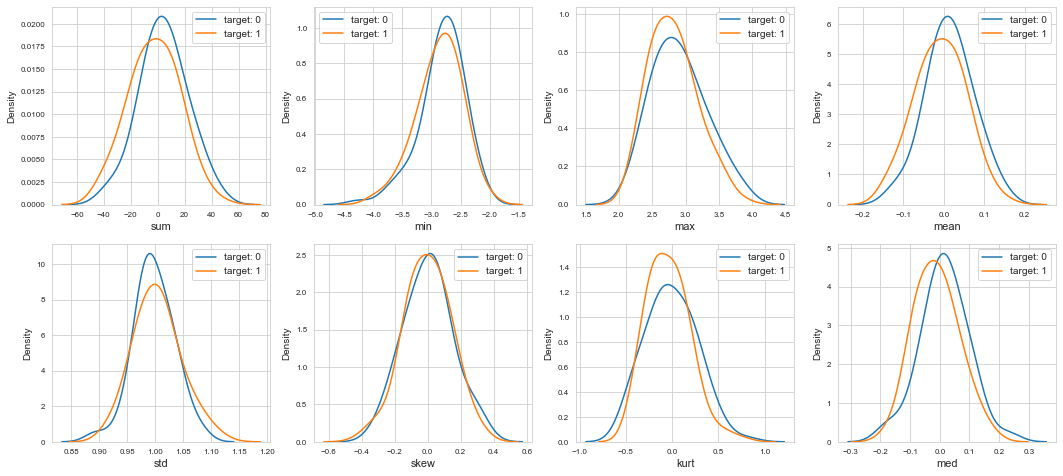

In [7]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[302:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features);

Distribution of new features values for train and test:

<Figure size 432x288 with 0 Axes>

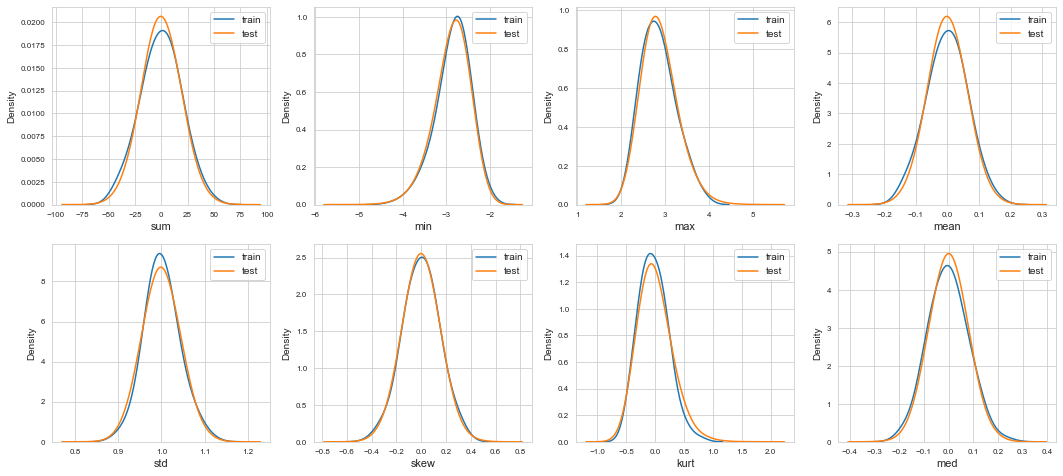

In [8]:
features = train.columns.values[302:]
plot_new_feature_distribution(train, test, 'train', 'test', features)

Checking how many features there are now:

In [9]:
print('Train and test columns: {} {}'.format(len(train.columns), len(test.columns)))

Train and test columns: 310 309


### Data augmentation

In [10]:
def apply_noise(data, noise_level):
    idxt = data[['id', 'target']]
    features = data.columns.values[2:]
    appended_data = []
    for feature in features:
        signal = data[feature]
        noise_factor = (np.abs(signal)).mean() * noise_level
        noise =  np.random.normal(0, noise_level, signal.shape)
        jittered = signal + noise
        appended_data.append(pd.DataFrame(jittered))
    appended_data = pd.concat(appended_data, axis=1)
    data_jittered = pd.concat([idxt, pd.DataFrame(appended_data)], axis=1)
    return data_jittered

In [11]:
noise_train = []
for i in tqdm_notebook(range(0,2)):
    t = apply_noise(train, noise_level = i * 0.025)
    noise_train.append(t)
noise_train = pd.concat(noise_train, axis = 0)

  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
print("Train shape with additional rows with noise added:",noise_train.shape)
train = noise_train

Train shape with additional rows with noise added: (500, 310)


### Balancing data

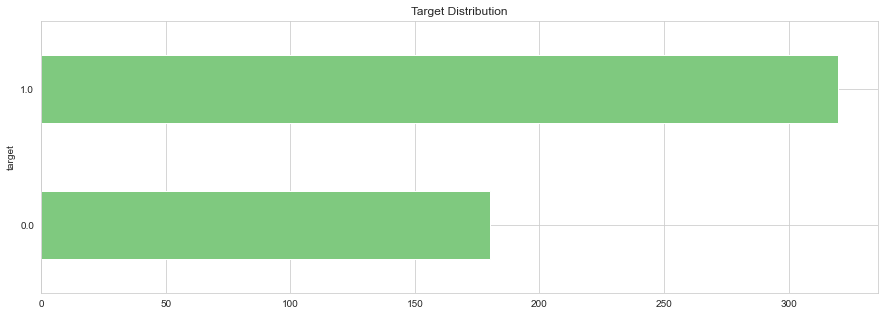

In [13]:
train.groupby('target').count()['id'].plot(kind='barh', title='Target Distribution', figsize=(15, 5), cmap="Accent")
plt.show()

In [14]:
target = train['target']
test = test.drop(['id'], axis=1)

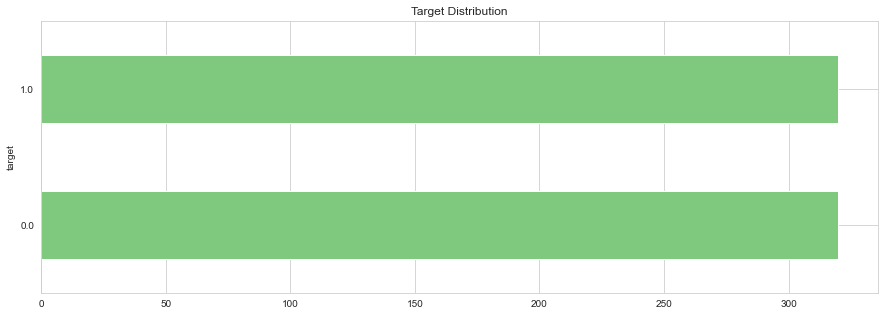

In [15]:
sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=3, n_jobs = 5)
train, target = sm.fit_resample(train, target)
train.groupby('target').count()['id'].plot(kind='barh', title='Target Distribution', figsize=(15, 5), cmap="Accent")
plt.show()

#### PCA

In [16]:
labels = train.drop(['id', 'target'], axis=1)

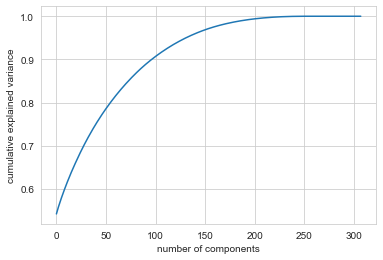

In [17]:
pca = PCA().fit(labels)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Scaling and spliting

In [18]:
sc=RobustScaler()
labels=sc.fit_transform(labels)
test=sc.transform(test)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    labels, target, test_size=0.3, random_state=RANDOM_STATE)

# Models

## Random forest classifier

#### Baseline model

In [20]:
params = {
        'n_estimators': 4500,
        'min_samples_split':5, 
        'min_samples_leaf':3,
        'min_weight_fraction_leaf':0.2,
        'max_depth':5, 
        'min_impurity_decrease':0,
        'max_leaf_nodes':50,
        'random_state':RANDOM_STATE
        }

In [21]:
rfc = RandomForestClassifier(**params)

rfc.fit(X_train, y_train)
y_train_pred = rfc.predict_proba(X_train)
y_test_pred = rfc.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Train f1:0.9653579676674364 | Test f1:0.877005347593583


#### AUC-ROC

In [22]:
fpr, tpr, thresh = roc_curve(y_test, y_test_pred[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test, y_test_pred[:,1])
print(auc_score1)

0.9683695652173913


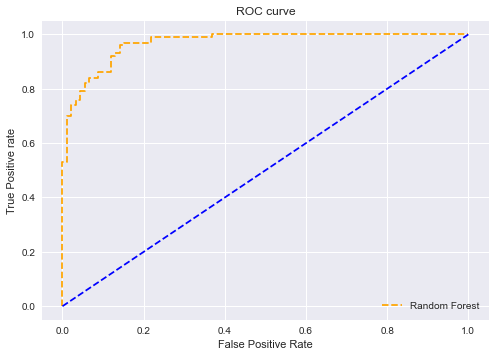

In [24]:
plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Logs

In [25]:
run = neptune.init(project='mila1/kaggle-335',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkMzdkYWQxNi1iYjlmLTRlODktOTZiZi1mYjY0MjkwM2FkYTYifQ==')
run["parameters"] = params
run["sys/tags"].add(["random"])
run["train/f1"] = train_f1
run["test/f1"] = test_f1
run.stop()

Info (NVML): Insufficient Permissions. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/mila1/kaggle-335/e/KAG-67
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 22 operations to synchronize with Neptune. Do not kill this process.


All 22 operations synced, thanks for waiting!


#### Hyperparameter optimization

In [914]:
rfc.get_params().keys()
skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = RANDOM_STATE)

In [917]:
%%time

parameter_grid = {
    "n_estimators": [2000,4000,5000],
    "min_samples_split": [4, 5, 6],
    "min_samples_leaf": [2,3,4]
                 }

grid_search = GridSearchCV(rfc, param_grid=parameter_grid, cv=skf.split(X_train,y_train), scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8761174968071519
Best parameters: {'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4000}
Wall time: 2min 37s


#### RFE

In [26]:
best_params = {
        'n_estimators': 4000,
        'min_samples_split':4, 
        'min_samples_leaf':2,
        'min_weight_fraction_leaf':0.2,
        'max_depth':5, 
        'min_impurity_decrease':0,
        'max_leaf_nodes':50,
        'random_state':RANDOM_STATE
        }
rfc = RandomForestClassifier(**best_params)
rfc.fit(X_train, y_train)

selector = RFE(estimator=rfc, 
          n_features_to_select=100, step=10)
selector.fit(X_train, y_train)

y_train_pred = selector.predict_proba(X_train)
y_test_pred = selector.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Train f1:0.951048951048951 | Test f1:0.8571428571428572


#### Submission

In [27]:
rfc_pred = selector.predict(test)
output = pd.DataFrame({'Id': sample['id'],
                       'Target': rfc_pred})
output.to_csv('RandomForestClassifier.csv', index=False)
output.head()

,Id,Target
0,250,0.0
1,251,1.0
2,252,0.0
3,253,1.0
4,254,1.0


## Logistic regression

#### Baseline model

In [28]:
params = {
    'C':0.1,  
    'fit_intercept':True, 
    'intercept_scaling':1, 
    'max_iter':1000, 
    'solver':'liblinear', 
    'random_state':RANDOM_STATE
}

In [29]:
log=LogisticRegression(**params)
log.fit(X_train, y_train)
y_train_pred = log.predict_proba(X_train)
y_test_pred = log.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Train f1:1.0 | Test f1:0.9690721649484536


#### AUC-ROC

In [30]:
fpr, tpr, thresh = roc_curve(y_test, y_test_pred[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test, y_test_pred[:,1])
print(auc_score1)

0.9873913043478261


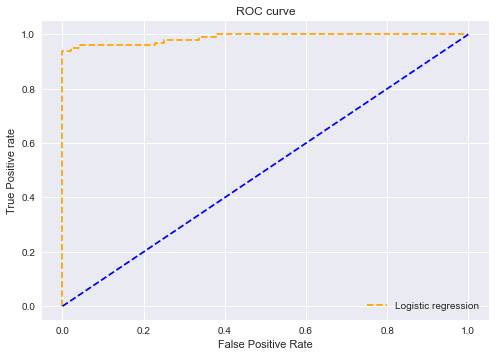

In [31]:
plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Logs

In [970]:
run = neptune.init(project='mila1/kaggle-335',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkMzdkYWQxNi1iYjlmLTRlODktOTZiZi1mYjY0MjkwM2FkYTYifQ==')
run["parameters"] = params
run["sys/tags"].add(["logreg"])
run["train/f1"] = train_f1
run["test/f1"] = test_f1
run.stop()

https://app.neptune.ai/mila1/kaggle-335/e/KAG-66
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 31 operations to synchronize with Neptune. Do not kill this process.


All 31 operations synced, thanks for waiting!


#### Hyperparameter optimisation

In [995]:
#log.get_params().keys()
#skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = RANDOM_STATE)

In [996]:
#%%time

#parameter_grid = {
#    'penalty' : ['l2', None], 
#    'fit_intercept': [True,False],
#    'C' : [0.001,0.1,10.0,100.0],
#    'max_iter':[10,100,1000,10000],
#    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#                }

#grid_search = GridSearchCV(log, param_grid=parameter_grid, cv=skf.split(X_train,y_train), scoring='roc_auc')
#grid_search.fit(X_train, y_train)
#print('Best score: {}'.format(grid_search.best_score_))
#print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9681818181818181
Best parameters: {'C': 10.0, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}
Wall time: 54.2 s


#### RFE

In [32]:
selector = RFE(estimator=log, 
          n_features_to_select=10, step=100)
selector.fit(X_train, y_train)

y_train_pred = selector.predict_proba(X_train)
y_test_pred = selector.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Train f1:0.8113207547169811 | Test f1:0.8223350253807107


#### Submission

In [33]:
log_preds = selector.predict(test)
output = pd.DataFrame({'Id': sample['id'],
                       'Target': log_preds})
output.to_csv('LogisticRegression.csv', index=False)
output.head()

,Id,Target
0,250,1.0
1,251,0.0
2,252,1.0
3,253,1.0
4,254,1.0


## SVC

#### Baseline model

In [34]:
params = {
    'probability':True, 
    'gamma':'scale', 
    'random_state':RANDOM_STATE
}

In [35]:
from sklearn.svm import SVC
svc = SVC(**params)
svc.fit(X_train, y_train)
y_train_pred = svc.predict_proba(X_train)
y_test_pred = svc.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Train f1:1.0 | Test f1:0.98


### AUC-ROC

In [36]:
fpr, tpr, thresh = roc_curve(y_test, y_test_pred[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test, y_test_pred[:,1])
print(auc_score1)

0.9984782608695653


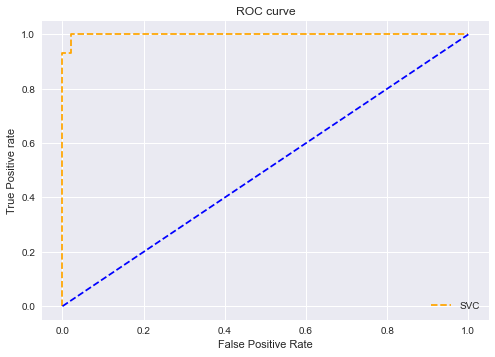

In [37]:
plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--',color='orange', label='SVC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Logs

In [116]:
run = neptune.init(project='mila1/kaggle-335',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkMzdkYWQxNi1iYjlmLTRlODktOTZiZi1mYjY0MjkwM2FkYTYifQ==')
run["parameters"] = params
run["sys/tags"].add(["svc"])
run["train/f1"] = train_f1
run["test/f1"] = test_f1
run.stop()

https://app.neptune.ai/mila1/kaggle-335/e/KAG-56
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 19 operations to synchronize with Neptune. Do not kill this process.


All 19 operations synced, thanks for waiting!


#### Hyperparameter tuning

In [39]:
svc.get_params().keys()
skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = RANDOM_STATE)

In [1253]:
parameter_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'kernel': ['linear', 'poly', 'rbf'],
                 }

grid_search_svc = GridSearchCV(svc, param_grid=parameter_grid, cv=skf.split(X_train,y_train), scoring='roc_auc', n_jobs=-1)
grid_search_svc.fit(X_train, y_train)
print('Best score: {}'.format(grid_search_svc.best_score_))
print('Best parameters: {}'.format(grid_search_svc.best_params_))

Best score: 0.9798245614035087
Best parameters: {'C': 10.0, 'kernel': 'poly'}


In [38]:
svc = SVC(probability=True, gamma='scale', C= 1.0, kernel= 'poly')
svc.fit(X_train, y_train)

y_train_pred = svc.predict_proba(X_train)
y_test_pred = svc.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Train f1:1.0 | Test f1:0.99009900990099


#### Submission

In [40]:
log_preds = svc.predict(test)
output = pd.DataFrame({'Id': sample['id'],
                       'Target': log_preds})
output.to_csv('LogisticRegression.csv', index=False)
output.head()

,Id,Target
0,250,1.0
1,251,1.0
2,252,1.0
3,253,1.0
4,254,1.0


## Cross Validation

In [47]:
for model_type in [
    RandomForestClassifier, 
    LogisticRegression,
    SVC
                  ]:
    clf = model_type()
    kfold = KFold(n_splits=5, shuffle=True)
    cv = ShuffleSplit(n_splits=100, test_size=0.25, random_state=RANDOM_STATE)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc')
    print("{} Accuracy: {} (+/- {})".format(model_type.__name__, scores.mean(), scores.std() * 2))

RandomForestClassifier Accuracy: 0.9787042648498655 (+/- 0.023710291754663382)
LogisticRegression Accuracy: 0.9689627361943388 (+/- 0.034812018527972104)
SVC Accuracy: 0.9832882747056546 (+/- 0.017896715264394385)


### Stacking

In [42]:
from mlxtend.classifier import StackingClassifier

m = StackingClassifier(
    classifiers=[
        LogisticRegression(),
        RandomForestClassifier(),
        SVC(probability=True)
    ],
    use_probas=True,
    meta_classifier=LogisticRegression()
)

m.fit(X_train, y_train)

StackingClassifier(classifiers=[LogisticRegression(), RandomForestClassifier(),
                                SVC(probability=True)],
                   meta_classifier=LogisticRegression(), use_probas=True)

In [43]:
y_train_pred = m.predict_proba(X_train)
y_test_pred = m.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Train f1:1.0 | Test f1:0.9690721649484536


In [45]:
preds = m.predict(test)
output = pd.DataFrame({'Id': sample['id'],
                       'Target': preds})
output.to_csv('stacked.csv', index=False)
output.head()

,Id,Target
0,250,0.0
1,251,1.0
2,252,1.0
3,253,1.0
4,254,1.0
